# Investment crowdfunding has little faith in sustainability! At least for the moment.

## Journal:

*Venture Capital*, 25:1, 91-115, 2023, [DOI: 10.1080/13691066.2022.2129510](https://doi.org/10.1080/13691066.2022.2129510)

## Authors:

Carmen Mendoza

Isabel María Parra Oller

Álvaro Rezola (@alvarorezola)

Nuria Suárez

In [1]:
# Import libraries
import pandas as pd
import locale
import math
import warnings
import numpy as np
from scipy import stats
from scipy.stats import norm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.linear_model import LogisticRegression, LinearRegression
from statsmodels.api import add_constant
from IPython.display import display, Markdown
from statsmodels.discrete.discrete_model import Probit
from scipy.stats import f
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
# Function definition
def significance_stars(pvalue):
    if pvalue < 0.01:
        return '***'
    elif pvalue < 0.05:
        return '**'
    elif pvalue < 0.1:
        return '*'
    else:
        return '-'
    
def summary_with_stars(model):
    # get the summary table as a DataFrame
    summary_df = model.summary2().tables[1]
    
    # create a new column for stars
    summary_df['stars'] = summary_df['P>|z|'].apply(significance_stars)

    # return the modified summary table
    return summary_df.round(4)

def confidence_interval(X1, X2):
    #calculate degrees of freedom
    df = len(X1) + len(X2) - 2

    #calculate standard error
    s1 = np.var(X1, ddof=1)
    s2 = np.var(X2, ddof=1)
    n1 = len(X1)
    n2 = len(X2)
    standard_error = np.sqrt((s1/n1) + (s2/n2))

    #calculate margin of error
    margin_of_error = stats.t.ppf(0.95, df) * standard_error

    #calculate confidence interval
    lower_limit = (np.mean(X1) - np.mean(X2)) - margin_of_error
    upper_limit = (np.mean(X1) - np.mean(X2)) + margin_of_error

    return lower_limit, upper_limit

# calculamos el logit del puntuaje de propensión para emparejar
def logit(p):
    logit_value = math.log(p/(1 - p))
    return logit_value

# calcular standard errors ATE
def ate_se(df):
    # obtener el numero de observaciones de cada grupo
    n_t = df[df.sustainable == 1].shape[0]
    n_c = df[df.sustainable == 0].shape[0]
    
    # obtener la varianza de los resultados en cada grupo
    s_t = df[df.sustainable == 1].exito.var()
    s_c = df[df.sustainable == 0].exito.var()
    
    # calcular error estandar del ATE usando la fórmula
    se = np.sqrt((s_t / n_t) + (s_c / n_c))
    
    return se

# Implementing the caliper 1-to-1 matching method
def caliper_match(df, threshold):
    # ordenar los datos por ps_logit y crear una columna con el índice original
    df_sorted = df.sort_values("ps_logit").reset_index()
    df_sorted["orig_index"] = df_sorted.index
    
    # crear listas vacias para almacenar los indices emparejados y no emparejados
    matched_index = []
    unmatched_index = []
    
    # iterar sobre las filas del dataframe ordenado
    for i in range(len(df_sorted)):
        row = df_sorted.iloc[i]
        if i not in matched_index: # si la fila no está emparejada todavía
            potential_matches = df_sorted[(df_sorted.sustainable != row.sustainable) & (abs(df_sorted.ps_logit - row.ps_logit) <= threshold)]
            
            # encontrar las filas potenciales que tienen un tratamiento diferente y una diferencia de ps_logit menor o igual al umbral
            
            if len(potential_matches) > 0: # si hay al menos una fila potencialmente emparejable
                closest_match_index = potential_matches.iloc[0].orig_index
                # Tomar la priemra fila potencial como la más cercana
                
                matched_index.append(i)
                matched_index.append(closest_match_index)
                # añadir ambos índices a la lista de emparejados
                
            else:
                unmatched_index.append(i)
                # si no hay ninguna fila potencialmente emparejable, añadir el índice a la lista d eno emparejados
    return matched_index, unmatched_index

# Implementing the nearest neighbour 1-to-1 matching method
def nearest_match(df, treat_col):
    # sort the data by ps_logit and create a column with the original index
    df_sorted = df.sort_values("ps_logit").reset_index()
    df_sorted["orig_index"] = df_sorted.index
    
    # create empty lists to store matched and unmatched indices
    matched_index = []
    unmatched_index = []
    
    # iterate over the rows of the sorted dataframe
    for i in range(len(df_sorted)):
        row = df_sorted.iloc[i]
        if i not in matched_index: # if the row is not matched yet
            potential_matches = df_sorted[(df_sorted[treat_col] != row[treat_col]) & (df_sorted.index > i)]
            if len(potential_matches) > 0:
                nearest_match = potential_matches.iloc[0]
                matched_index.append(i)
                matched_index.append(nearest_match.name)
            else:
                unmatched_index.append(i)
    
    return matched_index, unmatched_index

# Abadie and Imbens (2006, 2011) bias-corrected estimator
def nn_VBC_matching(df, covariates, treatment_col, k=1):
    # Extract treatment and control groups
    treated = df[df[treatment_col] == 1][covariates].values
    control = df[df[treatment_col] == 0][covariates].values

    # Extract outcome variable
    y = df[treatment_col].values

    # Extract propensity scores from dataframe
    propensity_scores = df['ps_logit'].values

    # Match treated and control observations using nearest neighbor matching
    matches = []
    unmatched = []
    for i in range(len(treated)):
        distances = np.abs(propensity_scores[:len(treated)] - propensity_scores[len(treated) + i])
        match_indices = np.argsort(distances)[:k]
        if distances[match_indices[0]] < np.inf:
            matches.append((i, match_indices))
            propensity_scores[len(treated) + match_indices] = np.inf
        else:
            unmatched.append(i)

    # Estimate average treatment effect using simple matching estimator
    ate = np.mean([y[treated_index] - np.mean(y[control_indices]) for treated_index, control_indices in matches])

    # Estimate average treatment effect using bias-corrected matching estimator
    X = np.vstack((treated[matches[0][0]], control[matches[0][1]]))
    y_matched = y[np.hstack(([matches[0][0]], matches[0][1]))]
    for i in range(1, len(matches)):
        X = np.vstack((X, treated[matches[i][0]], control[matches[i][1]]))
        y_matched = np.hstack((y_matched, y[np.hstack(([matches[i][0]], matches[i][1]))]))
    lin_reg = LinearRegression()
    lin_reg.fit(X, y_matched)
    y_fitted = lin_reg.predict(X)
    residuals = y_matched - y_fitted
    ate_bc = ate - np.mean(residuals[:len(treated)]) + np.mean(residuals[len(treated):])

    # Return matched and unmatched indices
    matched_index = [treated_index for treated_index, _ in matches]
    unmatched_index = unmatched

    return matched_index, unmatched_index

In [3]:
# Import data
stata_dataset = "/home/alvaro/Desktop/MendozaEtAl2023-VC/Data/CROWD_SUSTAINABILITY_FINAL.dta"
df = pd.read_stata(stata_dataset)

# Prepare data-set
df.drop(index=range(3679,len(df)), inplace=True)
df = df[df["form_c"] == 1]
df["deadline"] = pd.to_datetime(df["deadline"])
df["datestart"] = pd.to_datetime(df["datestart"])
df["dateincorporation"] = pd.to_datetime(df["dateincorporation"])
df = df[df["deadline"] <= "2019-10-01"]
df["totalassetsmostrecent1"] += 1e-6
df["logtotalassetsmostrecent1"] = np.log(df["totalassetsmostrecent1"])
df = df.dropna(subset=["desastre6meses"])
df['desastre12meses_indemnizaciones'].fillna(0, inplace=True)
df["desastre12meses_indemnizaciones"] += 1e-6
df["log_desastre12meses_ind"] = np.log(df["desastre12meses_indemnizaciones"])

# Bank Net Income to Total Assets as value of the ratio net income-to-total assets in the banking sector per state and year.
df["bank_netincome_assets"] = df["lagnetinc"]/df["lagasset"]*100
df['bank_netincome_assets'].fillna(0, inplace=True)
df['banknetincome_assets_number'] = df['bank_netincome_assets']*df['lagbanks']
df['banknetincome_assets_number'].fillna(0, inplace=True)

# fill empty bank data
df['lagbranches'].fillna(0, inplace=True)
df['bank_netincome_assets'].fillna(0, inplace=True)
df['lagvcfundraising'].fillna(0, inplace=True)
df['loglagnum_oper_por_platf_y'].fillna(0, inplace=True)

# Treatment and control dataframes
df_sust = df[df["sustainable"] == 1]
df_non_sust = df[df["sustainable"] == 0]

# Fixed effect variables
year_dummies = ["yr2c"]
for i in range(3, 19):
    year_dummies.append(f"yr{i}c")
industry_dummies = ["ind2c"]
for i in range(3, 69):
    industry_dummies.append(f"ind{i}c")
state_dummies = ["state2c"]
for i in range(3, 63):
    state_dummies.append(f"state{i}c")

There are 1,766 investment crowdfunding campaings issued under the Form C exemption from May 1st, 2016 until September 10th, 2019.

### Table 1 (a): Descriptive statistics
This table shows the descriptive statistics – mean, standard deviation, 25th percentile, median, 75th percentile – of the main variables of interest.

In [4]:
df[["exito",
    "quick75relative",
    "sustainable",
    "totalassetsmostrecent1",
    "employees",
    "loglife",                     # Age as in np.log(date_diff(start, incorporation))              
    "equity",                     
    "asked",
    "lagbranches",                 # Bank branches
    "bank_netincome_assets",       # Ratio Net Income to Total Assets (after we will use banknetincome_assets_number)
    "lagvcfundraising",            # VC fundraising (not sure if then I need to do the np.log())
    "loglagnum_oper_por_platf_y",  # Number of offerings per platform
    ]].describe().round(4)


,exito,quick75relative,sustainable,totalassetsmostrecent1,employees,loglife,equity,asked,lagbranches,bank_netincome_assets,lagvcfundraising,loglagnum_oper_por_platf_y
count,1766.0000,1766.0000,1766.0000,1.766000e+03,1766.0000,1765.0000,1766.0000,1.766000e+03,1766.0000,1766.0000,1766.0000,1766.0000
mean,0.3465,0.0266,0.1518,3.346530e+05,5.3618,6.1020,0.2701,7.045705e+04,3954.5379,1.0372,7890.5859,67.9219
std,0.4760,0.1610,0.3589,1.762435e+06,10.3144,1.4644,0.4441,1.185048e+05,2366.3217,0.5588,10870.1514,65.6488
min,0.0000,0.0000,0.0000,0.000000e+00,0.0000,0.6900,0.0000,1.000000e+03,0.0000,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000,0.000000e+00,1.0000,5.3200,0.0000,1.000000e+04,1447.0000,0.8187,56.3600,9.0000
50%,0.0000,0.0000,0.0000,2.656100e+04,3.0000,6.3500,0.0000,2.500000e+04,4260.0000,0.8857,600.0000,37.0000
75%,1.0000,0.0000,0.0000,2.032070e+05,6.0000,7.1500,1.0000,7.875000e+04,6728.0000,1.0918,20763.0996,110.0000
max,1.0000,1.0000,1.0000,5.812937e+07,225.0000,9.8700,1.0000,1.070000e+06,6868.0000,4.9257,33174.1797,262.0000


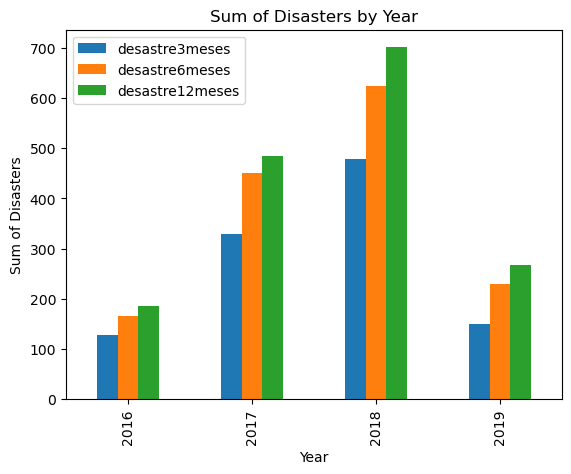

Average values by year:
      desastre3meses  desastre6meses  desastre12meses
year                                                 
2016        0.661458        0.859375         0.963542
2017        0.629063        0.860421         0.925430
2018        0.628947        0.819737         0.922368
2019        0.512027        0.786942         0.920962

Sum of cases by year:
      desastre3meses  desastre6meses  desastre12meses
year                                                 
2016           127.0           165.0            185.0
2017           329.0           450.0            484.0
2018           478.0           623.0            701.0
2019           149.0           229.0            268.0

T-statistic difference of means: 23.9304835595473
P-value for significance: 2.0655979674313165e-117


In [5]:
# exclusion restriction
df['year'] = pd.DatetimeIndex(df['datestart']).year

# bar chart
df.groupby('year').sum().plot(kind='bar', y=['desastre3meses', 'desastre6meses', 'desastre12meses'])
plt.title('Sum of Disasters by Year')
plt.xlabel('Year')
plt.ylabel('Sum of Disasters')
plt.show()

# estimate t-statistic difference of means and p-value
tstat, pvalue = stats.ttest_ind(df['desastre12meses'], df['desastre3meses'])

# calculate average values by year
avg_df = df.groupby('year').mean()[['desastre3meses', 'desastre6meses', 'desastre12meses']]

# calculate sum of cases by year
sum_df = df.groupby('year').sum()[['desastre3meses', 'desastre6meses', 'desastre12meses']]

# display tables
print('Average values by year:')
print(avg_df)
print('\nSum of cases by year:')
print(sum_df)
print('\nT-statistic difference of means:', tstat)
print('P-value for significance:', pvalue)

# el numero de desastres no está correlacionado con el éxito pero sí con el numero de ofertas sostenibles?

 ### Table 1 (b): Mean differences across subsamples
 This table shows the mean values of the main variables across the two subsamples of offerings and the T-statistic for the mean differences.

In [6]:
data = {
    "success": (df_non_sust["exito"],df_sust["exito"]),
    "quick75relative": (df_non_sust["quick75relative"],df_sust["quick75relative"]),
    "totalassetsmostrecent1": (df_non_sust["totalassetsmostrecent1"],df_sust["totalassetsmostrecent1"]),
    "employees": (df_non_sust["employees"],df_sust["employees"]),
    "loglife": (df_non_sust["loglife"],df_sust["loglife"]),
    "equity": (df_non_sust["equity"],df_sust["equity"]),
    "asked": (df_non_sust["asked"],df_sust["asked"]),
    "lagbranches": (df_non_sust["lagbranches"],df_sust["lagbranches"]),
    "banknetincome_assets_number": (df_non_sust["banknetincome_assets_number"], df_sust["banknetincome_assets_number"]),
    "lagvcfundraising": (df_non_sust["lagvcfundraising"],df_sust["lagvcfundraising"]),
    "loglagnum_oper_por_platf_y": (df_non_sust["loglagnum_oper_por_platf_y"],df_sust["loglagnum_oper_por_platf_y"]),
}

results = {}

for key in data:
    group1 = data[key][0].round(4)
    group2 = data[key][1].round(4)

    # calculate t-statistic    
    t_statistic, p_value = stats.ttest_ind(group1, group2, nan_policy="omit")
    
    # Indicate statistical significance at different levels
    significance = significance_stars(p_value)
    
    # calculate mean of each variable
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)

    results[key]={'non sustainable':mean_group1.round(4),
                  'sustainable':mean_group2.round(4),
                  't-statistic':t_statistic.round(4),
                  'p-value':p_value.round(4),
                  'significance':significance}
# Display results
pd.DataFrame(results).T

,non sustainable,sustainable,t-statistic,p-value,significance
success,0.3411,0.3769,-1.1323,0.2577,-
quick75relative,0.0274,0.0224,0.4664,0.641,-
totalassetsmostrecent1,327075.5,377007.5625,-0.4271,0.6694,-
employees,5.492,4.6343,1.2539,0.21,-
loglife,6.0673,6.2959,-2.3562,0.0186,**
equity,0.2617,0.3172,-1.8848,0.0596,*
asked,70123.804688,72319.789062,-0.2793,0.78,-
lagbranches,4031.6529,3523.5,3.2465,0.0012,***
banknetincome_assets_number,139.8272,107.903,3.805,0.0001,***
lagvcfundraising,7952.54541,7544.255371,0.5662,0.5713,-


### Table 2: Propensity Score Matching 
This table shows the mean values of the main variables across the two subsamples of offerings and the t-statistics obtained for the differences between the means across groups of offerings, before matching and after matching using caliper, nearest 1-to-1 and nn-VBC methods.

In [7]:
# Test for heteroskedascity to understand if we should use robust standard errors

In [8]:
# Two probit functions to validate covariates
formula_treatment = f"sustainable ~ logtotalassetsmostrecent1 + logemployees1 + logasked1"
treatment_model = smf.probit(formula=formula_treatment, data=df).fit(cov_type='HC0', disp=False)

# Get log-likelihood
log_likelihood = treatment_model.llf

# Get Wald chi-squared test statistic and p-value
wald_test = treatment_model.wald_test(treatment_model.model.exog_names)
wald_chi2 = wald_test.statistic[0][0]
wald_pvalue = wald_test.pvalue

print(f'Log-Likelihood: {log_likelihood:.4f}')
print(f'Wald Chi-Squared: {wald_chi2:.4f}')
print(f'Wald p-value: {wald_pvalue:.4f}')

summary_with_stars(treatment_model)

Log-Likelihood: -749.1635
Wald Chi-Squared: 801.8215
Wald p-value: 0.0000


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],stars
Intercept,-0.3984,0.3555,-1.1206,0.2625,-1.0953,0.2984,-
logtotalassetsmostrecent1,0.0046,0.0035,1.3255,0.1850,-0.0022,0.0115,-
logemployees1,-0.0760,0.0455,-1.6700,0.0949,-0.1651,0.0132,*
logasked1,-0.0524,0.0336,-1.5611,0.1185,-0.1182,0.0134,-


In [9]:
formula_outcome = f"exito ~ logtotalassetsmostrecent1 + logemployees1 + logasked1"
outcome_model = smf.probit(formula=formula_outcome, data=df).fit(cov_type='HC0', disp=False)

# Get log-likelihood
log_likelihood = outcome_model.llf

# Get Wald chi-squared test statistic and p-value
wald_test = outcome_model.wald_test(outcome_model.model.exog_names)
wald_chi2 = wald_test.statistic[0][0]
wald_pvalue = wald_test.pvalue

print(f'Log-Likelihood: {log_likelihood:.4f}')
print(f'Wald Chi-Squared: {wald_chi2:.4f}')
print(f'Wald p-value: {wald_pvalue:.4f}')

summary_with_stars(outcome_model)

Log-Likelihood: -1105.5368
Wald Chi-Squared: 227.5048
Wald p-value: 0.0000


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],stars
Intercept,1.4975,0.2894,5.1741,0.0000,0.9302,2.0647,***
logtotalassetsmostrecent1,0.0035,0.0030,1.1485,0.2508,-0.0024,0.0094,-
logemployees1,0.1272,0.0392,3.2428,0.0012,0.0503,0.2041,***
logasked1,-0.2019,0.0272,-7.4254,0.0000,-0.2552,-0.1486,***


### Table 2 (A): Before Matching

In [10]:
df[["exito", "quick75relative", "logtotalassetsmostrecent1", "logemployees1", "logasked1"]].describe()
df_sust = df[df["sustainable"] == 1]
df_non_sust = df[df["sustainable"] == 0]

data = {
    "success": (df_sust["exito"], df_non_sust["exito"]),
    "quick75relative": (df_sust["quick75relative"], df_non_sust["quick75relative"]),
    "logtotalassetsmostrecent1": (df_sust["logtotalassetsmostrecent1"], df_non_sust["logtotalassetsmostrecent1"]),
    "logemployees1": (df_sust["logemployees1"], df_non_sust["logemployees1"]),
    "logasked1": (df_sust["logasked1"], df_non_sust["logasked1"])
}

results = {}

for key in data:
    group1 = data[key][0].round(4)
    group2 = data[key][1].round(4)

    # calculate t-statistic    
    t_statistic, p_value = stats.ttest_ind(group1, group2, nan_policy="omit")
    
    # Indicate statistical significance at different levels
    significance = significance_stars(p_value)
        
    # calculate mean of each variable
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)

    results[key]={'sustainable':mean_group1.round(4),
                  'non_sustainable':mean_group2.round(4),
                  "difference" :(mean_group1 - mean_group2).round(4),
                  't-statistic':t_statistic.round(4),
                  'p-value':p_value.round(4),
                  'significance':significance}
# Display results
pd.DataFrame(results).T


,sustainable,non_sustainable,difference,t-statistic,p-value,significance
success,0.3769,0.3411,0.0357,1.1323,0.2577,-
quick75relative,0.0224,0.0274,-0.005,-0.4664,0.641,-
logtotalassetsmostrecent1,4.7336,4.2117,0.5219,0.6995,0.4843,-
logemployees1,1.3689,1.4347,-0.0658,-1.1744,0.2404,-
logasked1,10.3262,10.4339,-0.1077,-1.415,0.1572,-


### Table 2 (B): After Matching

In [11]:
# Logit model para estimar el puntaje de propensión (ps)
model = LogisticRegression()
df = df.dropna(axis = 1) # drop all variables that have empty values

# Independent variables
X = df[["logtotalassetsmostrecent1",
        "logemployees1",
        "logasked1"]]

# Dependent variable (treatment group)
y = df["sustainable"]

# Model adjustment & predicted probabilities
model.fit(X, y) 
pred_prob = model.predict_proba(X)
df["ps"] = pred_prob[:, 1]

df["ps_logit"] = df.ps.apply(logit)

# Caliper 1-to-1 method with 0.1 umbral
caliper_matched, caliper_unmatched = caliper_match(df[["sustainable", "logtotalassetsmostrecent1", "logemployees1", "logasked1", "ps_logit"]], 0.1)
caliper_df_matched = df.iloc[caliper_matched]

# Nearest 1-to-1 method
nearest_matched, nearest_unmatched = nearest_match(df[["sustainable", "logtotalassetsmostrecent1", "logemployees1", "logasked1", "ps_logit"]], "sustainable")
nearest_df_matched = df.iloc[nearest_matched]

# Nearest 1-to-1 method
nn_VBC_matched, nn_VBC_unmatched = nn_VBC_matching(df[["sustainable", "logtotalassetsmostrecent1", "logemployees1", "logasked1", "ps_logit"]],
                                                   ["logtotalassetsmostrecent1", "logemployees1", "logasked1"],
                                                   "sustainable")
nn_VBC_df_matched = df.iloc[nn_VBC_matched]


# mean of each variable in the treatment & control group
treatment_means_caliper = caliper_df_matched[caliper_df_matched["sustainable"] == 1]
control_means_caliper = caliper_df_matched[caliper_df_matched["sustainable"] == 0]
treatment_means_nearest = nearest_df_matched[nearest_df_matched["sustainable"] == 1]
control_means_nearest = nearest_df_matched[nearest_df_matched["sustainable"] == 0]
treatment_means_nn_VBC = nn_VBC_df_matched[nn_VBC_df_matched["sustainable"] == 1]
control_means_nn_VBC = nn_VBC_df_matched[nn_VBC_df_matched["sustainable"] == 0]

data_caliper = {
    "success": (treatment_means_caliper["exito"], control_means_caliper["exito"]),
    "quick75relative": (treatment_means_caliper["quick75relative"], control_means_caliper["quick75relative"]),
    "logtotalassetsmostrecent1": (treatment_means_caliper["logtotalassetsmostrecent1"], control_means_caliper["logtotalassetsmostrecent1"]),
    "logemployees1": (treatment_means_caliper["logemployees1"], control_means_caliper["logemployees1"]),
    "logasked1": (treatment_means_caliper["logasked1"], control_means_caliper["logasked1"])
}

data_nearest = {
    "success": (treatment_means_nearest["exito"], control_means_nearest["exito"]),
    "quick75relative": (treatment_means_nearest["quick75relative"], control_means_nearest["quick75relative"]),
    "logtotalassetsmostrecent1": (treatment_means_nearest["logtotalassetsmostrecent1"], control_means_nearest["logtotalassetsmostrecent1"]),
    "logemployees1": (treatment_means_nearest["logemployees1"], control_means_nearest["logemployees1"]),
    "logasked1": (treatment_means_nearest["logasked1"], control_means_nearest["logasked1"])
}

data_nn_VBC = {
    "success": (treatment_means_nn_VBC["exito"], control_means_nn_VBC["exito"]),
    "quick75relative": (treatment_means_nn_VBC["quick75relative"], control_means_nn_VBC["quick75relative"]),
    "logtotalassetsmostrecent1": (treatment_means_nn_VBC["logtotalassetsmostrecent1"], control_means_nn_VBC["logtotalassetsmostrecent1"]),
    "logemployees1": (treatment_means_nn_VBC["logemployees1"], control_means_nn_VBC["logemployees1"]),
    "logasked1": (treatment_means_nn_VBC["logasked1"], control_means_nn_VBC["logasked1"])
}

results_caliper = {}
results_nearest = {}
results_nn_VBC = {}

for key in data_caliper:
    group1_caliper = data_caliper[key][0].round(4)
    group2_caliper = data_caliper[key][1].round(4)
    
    group1_nearest = data_nearest[key][0].round(4)
    group2_nearest = data_nearest[key][1].round(4)
    
    group1_nn_VBC = data_nn_VBC[key][0].round(4)
    group2_nn_VBC = data_nn_VBC[key][1].round(4)

    # calculate t-statistic for Caliper method
    t_statistic_caliper, p_value_caliper = stats.ttest_ind(group1_caliper, group2_caliper, nan_policy="omit")
    t_statistic_nearest, p_value_nearest = stats.ttest_ind(group1_nearest, group2_nearest, nan_policy="omit")
    t_statistic_nn_VBC, p_value_nn_VBC = stats.ttest_ind(group1_nn_VBC, group2_nn_VBC, nan_policy="omit")

    # Indicate statistical significance at different levels
    significance_caliper = significance_stars(p_value_caliper)
    significance_nearest = significance_stars(p_value_nearest)
    significance_nn_VBC = significance_stars(p_value_nn_VBC)

    # calculate mean of each variable
    mean_group1_caliper = np.mean(group1_caliper)
    mean_group2_caliper = np.mean(group2_caliper)
    
    # calculate mean of each variable
    mean_group1_nearest = np.mean(group1_nearest)
    mean_group2_nearest = np.mean(group2_nearest)

    # calculate mean of each variable
    mean_group1_nn_VBC = np.mean(group1_nn_VBC)
    mean_group2_nn_VBC = np.mean(group2_nn_VBC)

    results_caliper[key]={'sustainable':mean_group1_caliper.round(4),
                          'non_sustainable':mean_group2_caliper.round(4),
                          "difference" :(mean_group1_caliper - mean_group2_caliper).round(4),
                          't-statistic':t_statistic_caliper.round(4),
                          'p-value':p_value_caliper.round(4),
                          'significance':significance_caliper}
    
    results_nearest[key]={'sustainable':mean_group1_nearest.round(4),
                          'non_sustainable':mean_group2_nearest.round(4),
                          "difference" :(mean_group1_nearest - mean_group2_nearest).round(4),
                          't-statistic':t_statistic_nearest.round(4),
                          'p-value':p_value_nearest.round(4),
                          'significance':significance_nearest}
    
    results_nn_VBC[key]={'sustainable':mean_group1_nn_VBC.round(4),
                          'non_sustainable':mean_group2_nn_VBC.round(4),
                          "difference" :(mean_group1_nn_VBC - mean_group2_nn_VBC).round(4),
                          't-statistic':t_statistic_nn_VBC.round(4),
                          'p-value':p_value_nn_VBC.round(4),
                          'significance':significance_nn_VBC}

# Display results
print("Panel A: Caliper 1-to-1")
display(pd.DataFrame(results_caliper).T)
print("Panel B: Nearest 1-to-1")
display(pd.DataFrame(results_nearest).T)
print("Panel C: nn-VBC")
display(pd.DataFrame(results_nn_VBC).T)

Panel A: Caliper 1-to-1


,sustainable,non_sustainable,difference,t-statistic,p-value,significance
success,0.3406,0.3066,0.0339,1.4682,0.1421,-
quick75relative,0.0174,0.0205,-0.0032,-0.4526,0.6509,-
logtotalassetsmostrecent1,5.0694,5.5395,-0.4701,-0.9023,0.367,-
logemployees1,1.3182,1.4825,-0.1643,-4.0574,0.0001,***
logasked1,10.4767,10.427,0.0497,0.8906,0.3732,-


Panel B: Nearest 1-to-1


,sustainable,non_sustainable,difference,t-statistic,p-value,significance
success,0.3856,0.3214,0.0642,2.5142,0.012,**
quick75relative,0.0154,0.0197,-0.0042,-0.5681,0.57,-
logtotalassetsmostrecent1,4.8445,4.7776,0.0669,0.1119,0.9109,-
logemployees1,1.3483,1.4899,-0.1416,-3.0396,0.0024,***
logasked1,10.4113,10.4425,-0.0312,-0.4853,0.6275,-


Panel C: nn-VBC


,sustainable,non_sustainable,difference,t-statistic,p-value,significance
success,0.4211,0.2614,0.1597,1.4785,0.1409,-
quick75relative,0.1053,0.0511,0.0541,0.9689,0.3338,-
logtotalassetsmostrecent1,4.6211,2.4905,2.1306,0.7416,0.4592,-
logemployees1,1.2242,1.2441,-0.0199,-0.1172,0.9069,-
logasked1,10.9644,11.1971,-0.2327,-1.1191,0.2645,-


### Table 3: Average Treatment Effect on the Treated (ATET) 
This table shows the average treatment effect on the treated individuals (ATET) for each method: caliper, nearest 1-to-1 and nn-VBC methods.

In [12]:
caliper_ate_success = caliper_df_matched.groupby("sustainable")["exito"].mean().diff().iloc[-1]
caliper_ate_quick = caliper_df_matched.groupby("sustainable")["quick75relative"].mean().diff().iloc[-1]
caliper_se = ate_se(caliper_df_matched)

nearest_ate_success = nearest_df_matched.groupby("sustainable")["exito"].mean().diff().iloc[-1]
nearest_ate_quick = nearest_df_matched.groupby("sustainable")["quick75relative"].mean().diff().iloc[-1]
nearest_se = ate_se(nearest_df_matched)

nn_VBC_ate_success = nn_VBC_df_matched.groupby("sustainable")["exito"].mean().diff().iloc[-1]
nn_VBC_ate_quick = nn_VBC_df_matched.groupby("sustainable")["quick75relative"].mean().diff().iloc[-1]
nn_VBC_se = ate_se(nn_VBC_df_matched)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
caliper_success_tstat, caliper_success_pvalue, caliper_success_desc = sms.ttest_ind(
    caliper_df_matched[caliper_df_matched.sustainable == 1].exito.values,
    caliper_df_matched[caliper_df_matched.sustainable == 0].exito.values,
    usevar="unequal",
    alternative="larger",
    value=0
)
lower_limit_success_caliper, upper_limit_success_caliper = confidence_interval(caliper_df_matched[caliper_df_matched.sustainable == 1].exito.values,
                                                               caliper_df_matched[caliper_df_matched.sustainable == 0].exito.values)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
nearest_success_tstat, nearest_success_pvalue, nearest_success_desc = sms.ttest_ind(
    nearest_df_matched[nearest_df_matched.sustainable == 1].exito.values,
    nearest_df_matched[nearest_df_matched.sustainable == 0].exito.values,
    usevar="unequal",
    alternative="larger",
    value=0
)
lower_limit_success_nearest, upper_limit_success_nearest = confidence_interval(nearest_df_matched[nearest_df_matched.sustainable == 1].exito.values,
                                                                               nearest_df_matched[nearest_df_matched.sustainable == 0].exito.values)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
caliper_quick_tstat, caliper_quick_pvalue, caliper_quick_desc = sms.ttest_ind(
    caliper_df_matched[caliper_df_matched.sustainable == 1].quick75relative.values,
    caliper_df_matched[caliper_df_matched.sustainable == 0].quick75relative.values,
    usevar="unequal",
    alternative="larger",
    value=0
)

lower_limit_quick_caliper, upper_limit_quick_caliper = confidence_interval(caliper_df_matched[caliper_df_matched.sustainable == 1].quick75relative.values,
                                                           caliper_df_matched[caliper_df_matched.sustainable == 0].quick75relative.values)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
nearest_quick_tstat, nearest_quick_pvalue, nearest_quick_desc = sms.ttest_ind(
    nearest_df_matched[nearest_df_matched.sustainable == 1].exito.values,
    nearest_df_matched[nearest_df_matched.sustainable == 0].exito.values,
    usevar="unequal",
    alternative="larger",
    value=0
)
lower_limit_quick_nearest, upper_limit_quick_nearest = confidence_interval(nearest_df_matched[nearest_df_matched.sustainable == 1].exito.values,
                                                                           nearest_df_matched[nearest_df_matched.sustainable == 0].exito.values)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
nn_VBC_quick_tstat, nn_VBC_quick_pvalue, nn_VBC_quick_desc = sms.ttest_ind(
    nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 1].exito.values,
    nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 0].exito.values,
    usevar="unequal",
    alternative="larger",
    value=0
)
lower_limit_quick_nn_VBC, upper_limit_quick_nn_VBC = confidence_interval(nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 1].exito.values,
                                                                         nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 0].exito.values)

# realizar una preuba de t de dos muestras independientes y obtener los valores p y los intervalso de confianza al 95%
nn_VBC_success_tstat, nn_VBC_success_pvalue, nn_VBC_success_desc = sms.ttest_ind(
    nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 1].exito.values,
    nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 0].exito.values,
    usevar="unequal",
    alternative="larger",
    value=0
)
lower_limit_success_nn_VBC, upper_limit_success_nn_VBC = confidence_interval(nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 1].exito.values,
                                                                             nn_VBC_df_matched[nn_VBC_df_matched.sustainable == 0].exito.values)

data_caliper = {"Modelo Caliper 1-to-1": ["success", "quickrelative75"],
                "ATE": [caliper_ate_success, caliper_ate_quick],
                "Error estándar": [caliper_se, caliper_se],
                "Valor p": [caliper_success_pvalue, caliper_quick_pvalue],
                "[Intervalo de": [lower_limit_success_caliper, lower_limit_quick_caliper],
                "confianza (95%)]": [upper_limit_success_caliper, upper_limit_quick_caliper]}

data_nearest = {"Modelo Nearest 1-to-1": ["success", "quickrelative75"],
                "ATE": [nearest_ate_success, nearest_ate_quick],
                "Error estándar": [nearest_se, nearest_se],
                "Valor p": [nearest_success_pvalue, nearest_quick_pvalue],
                "[Intervalo de": [lower_limit_success_nearest, lower_limit_quick_nearest],
                "confianza (95%)]": [upper_limit_success_nearest, upper_limit_quick_nearest]}

data_nn_VBC = {"Modelo Nearestnn-VBC": ["success", "quickrelative75"],
                "ATE": [nn_VBC_ate_success, nn_VBC_ate_quick],
                "Error estándar": [nn_VBC_se, nn_VBC_se],
                "Valor p": [nn_VBC_success_pvalue, nn_VBC_quick_pvalue],
                "[Intervalo de": [lower_limit_success_nn_VBC, lower_limit_quick_nn_VBC],
                "confianza (95%)]": [upper_limit_success_nn_VBC, upper_limit_quick_nn_VBC]}


display(pd.DataFrame(data_caliper).round(4))
display(pd.DataFrame(data_nearest).round(4))
display(pd.DataFrame(data_nn_VBC).round(4))

,Modelo Caliper 1-to-1,ATE,Error estándar,Valor p,[Intervalo de,confianza (95%)]
0,success,0.0339,0.0236,0.0755,-0.0049,0.0728
1,quickrelative75,-0.0032,0.0236,0.6845,-0.0140,0.0077


,Modelo Nearest 1-to-1,ATE,Error estándar,Valor p,[Intervalo de,confianza (95%)]
0,success,0.0642,0.0264,0.0076,0.0209,0.1076
1,quickrelative75,-0.0042,0.0264,0.0076,0.0209,0.1076


,Modelo Nearestnn-VBC,ATE,Error estándar,Valor p,[Intervalo de,confianza (95%)]
0,success,0.1597,0.121,0.1006,-0.0403,0.3597
1,quickrelative75,0.0541,0.121,0.1006,-0.0403,0.3597


### Table 4: Sustainability and success
This table presents IV results examining the effect of the sustainable orientation of investment crowdfunding offerings on the probability of success. The dependent variable in columns (1) and (2) is the dummy that identifies sustainable offerings. The dependent variable in columns (3) and (5) is SUCCESS. QUICK75 is the dependent variables in columns (4) and (6). Year, industry-year and state-year fixed effects are included.

$$
SUCCESSFUL_{ijklt} = \beta_0 + \beta_1SUSTAINABLE\_predicted_{ijklt} + \beta_2FIRM_{jklt-1} + \beta_3OFFERING_{ijklt} + \theta_k + \delta_l + \lambda_t + \epsilon_{ijklt}
$$

In [13]:
# First-Stage Dependent Variable:
y = df['sustainable']

# specifications table 4.1
columns = ['desastre6meses',
           'sizemostrecent1',
           'logemployees1',
           'edad',
           'equity',
           'logasked1',
           "ind_year",
           "state_id"] + year_dummies
X1 = df[columns]

# Drop dummies that have a constant value for all rows
nunique = X1[year_dummies].nunique()
X1 = X1.drop(columns = nunique[nunique == 1].index)

# fit model 4.1
model1 = Probit(y, X1).fit(cov_type='HC0', disp=False)
results1 = pd.DataFrame(model1.params.round(4), columns=["Sustainable 1"])
results1["pvalue"] = model1.pvalues.round(4)
results1.loc['Year Dummies', 'Sustainable 1'] = 'Yes'
results1.loc['Industry-Y Dummies', 'Sustainable 1'] = 'Yes'
results1.loc['State-Y Dummies', 'Sustainable 1'] = 'Yes'
results1['stars'] = results1["pvalue"].apply(significance_stars)
results1.loc['log_likelihood', 'Sustainable 1'] = model1.llf.round(4)
wald_test = model1.wald_test(model1.model.exog_names)
wald_chi2 = wald_test.statistic[0][0]
results1.loc['wald_pvalue', 'Sustainable 1'] = wald_test.pvalue.round(4)

# specifications table 4.2
columns = ['log_desastre12meses_ind',
           'sizemostrecent1',
           'logemployees1',
           'edad',
           'equity',
           'logasked1',
           "ind_year",
           "state_id"] + year_dummies

X2 = df[columns]

# Drop dummies that have a constant value for all rows
nunique = X2[year_dummies].nunique()
X2 = X2.drop(columns = nunique[nunique == 1].index)

# fit model 4.2
model42 = Probit(y, X2).fit(cov_type='HC0', disp=False)
results42 = pd.DataFrame(model42.params.round(4), columns=["Sustainable 2"])
results42["pvalue"] = model42.pvalues.round(4)
results42.loc['Year Dummies', 'Sustainable 2'] = 'Yes'
results42.loc['Industry-Y Dummies', 'Sustainable 2'] = 'Yes'
results42.loc['State-Y Dummies', 'Sustainable 2'] = 'Yes'
results42['stars'] = results42["pvalue"].apply(significance_stars)
results42.loc['log_likelihood', 'Sustainable 2'] = model42.llf.round(4)
wald_test = model42.wald_test(model42.model.exog_names)
wald_chi2 = wald_test.statistic[0][0]
results42.loc['wald_pvalue', 'Sustainable 2'] = wald_test.pvalue.round(4)

# Desired order
row_order = ["desastre6meses",
             "log_desastre12meses_ind",
             "sizemostrecent1",
             "logemployees1",
             "edad",
             "equity",
             "logasked1",
             "ind_year",
             "state_id",
             'Year Dummies',
             "Industry-Y Dummies",
             "State-Y Dummies",
             "log_likelihood",
             "wald_pvalue"]

pd.concat([results1, results42], axis=1).reindex(row_order).drop(['ind_year', 'state_id'])


,Sustainable 1,pvalue,stars,Sustainable 2,pvalue,stars
desastre6meses,-0.2929,0.0022,***,NaN,NaN,NaN
log_desastre12meses_ind,NaN,NaN,NaN,-0.0105,0.0079,***
sizemostrecent1,-0.0038,0.6747,-,-0.004,0.6573,-
logemployees1,-0.1211,0.0116,**,-0.119,0.0132,**
edad,0.0854,0.0074,***,0.087,0.0064,***
equity,0.1791,0.0405,**,0.177,0.0425,**
logasked1,-0.0391,0.2869,-,-0.0429,0.2392,-
Year Dummies,Yes,NaN,-,Yes,NaN,-
Industry-Y Dummies,Yes,NaN,-,Yes,NaN,-
State-Y Dummies,Yes,NaN,-,Yes,NaN,-


In [14]:
# Hausman test to estimate both a fixed effect model and random model. H0: differences between coefficients is not systematic

In [15]:
# Uses the fitted model to make predictions for the dependent variable on both specifications (sustainable)
df['sustainablep_disasterdummy'] = model1.predict(X1)
df['sustainablep_disastercosts'] = model42.predict(X2)

# Specificación 1 (success)

# Without desastre6meses
controls = ["sizemostrecent1",
           'logemployees1',
           'edad',
           'equity',
           "logasked1",
           "ind_year",
           "state_id"] + year_dummies

Table_43_and_44_controls = controls + ["sustainablep_disasterdummy"]
Table_45_and_46_controls = controls + ["sustainablep_disastercosts"]

X2 = df[Table_43_and_44_controls]
X3 = df[Table_45_and_46_controls]

# Drop dummies that have a constant value for all rows
nunique_2 = X2[year_dummies].nunique()
X2 = X2.drop(columns = nunique_2[nunique_2 == 1].index)

nunique_3 = X3[year_dummies].nunique()
X3 = X3.drop(columns = nunique_3[nunique_3 == 1].index)

y2 = df['exito']
y3 = df["quick75relative"]

models = [Probit(y2, X2).fit(cov_type='HC0', disp=False),
          Probit(y3, X2).fit(cov_type='HC0', disp=False),
          Probit(y2, X3).fit(cov_type='HC0', disp=False),
          Probit(y3, X3).fit(cov_type='HC0', disp=False)]

results = []
for i, model in enumerate(models):
    result = pd.DataFrame(model.params.round(4), columns=[f"model{i+43}"])
    result["pvalue"] = model.pvalues.round(4)
    result.loc['Observations', f"model{i+43}"] = model.nobs
    result.loc['Year Dummies', f"model{i+43}"] = 'Yes'
    result.loc['Industry-Y Dummies', f"model{i+43}"] = 'Yes'
    result.loc['State-Y Dummies', f"model{i+43}"] = 'Yes'
    result['stars'] = result["pvalue"].apply(significance_stars)
    result.loc['log_likelihood', f"model{i+43}"] = model.llf.round(4)
    wald_test = model.wald_test(model.model.exog_names)
    wald_chi2 = wald_test.statistic[0][0]
    result.loc['wald_pvalue', f"model{i+43}"] = wald_test.pvalue.round(4)
    if i < 2:
        result.loc['sustainable', f"model{i+43}"] = result.loc['sustainablep_disasterdummy', f"model{i+43}"]
        result.loc['sustainable', 'pvalue'] = result.loc['sustainablep_disasterdummy', 'pvalue']
        result.loc['sustainable', 'stars'] = result.loc['sustainablep_disasterdummy', 'stars']
    else:
        result.loc['sustainable', f"model{i+43}"] = result.loc['sustainablep_disastercosts', f"model{i+43}"]
        result.loc['sustainable', 'pvalue'] = result.loc['sustainablep_disastercosts', 'pvalue']
        result.loc['sustainable', 'stars'] = result.loc['sustainablep_disastercosts', 'stars']
    results.append(result)
    
# Desired order
row_order = ["desastre6meses",
             "log_desastre12meses_ind",
             "sustainable",
             "sizemostrecent1",
             "logemployees1",
             "edad",
             "equity",
             "logasked1",
             "ind_year",
             "state_id",
             'Year Dummies',
             "Industry-Y Dummies",
             "State-Y Dummies",
             "log_likelihood",
             "wald_pvalue",
             'Observations']

pd.concat(results, axis=1).reindex(row_order).drop(['ind_year', 'state_id'])


,model43,pvalue,stars,model44,pvalue,stars,model45,pvalue,stars,model46,pvalue,stars
desastre6meses,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_desastre12meses_ind,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sustainable,-2.4808,0.0198,**,-1.5125,0.4344,-,-2.2557,0.0650,*,-3.0911,0.1285,-
sizemostrecent1,-0.0041,0.6085,-,0.0032,0.8303,-,-0.0041,0.6124,-,0.0025,0.8687,-
logemployees1,0.0647,0.2019,-,-0.2907,0.0188,**,0.0707,0.1817,-,-0.3347,0.0076,***
edad,0.0975,0.0042,***,-0.0128,0.8411,-,0.0941,0.0082,***,0.0164,0.8068,-
equity,-0.1233,0.1617,-,-0.088,0.6564,-,-0.1339,0.1412,-,-0.0178,0.9249,-
logasked1,-0.2913,0.0000,***,-0.0057,0.9307,-,-0.2899,0.0000,***,-0.0228,0.7301,-
Year Dummies,Yes,NaN,-,Yes,NaN,-,Yes,NaN,-,Yes,NaN,-
Industry-Y Dummies,Yes,NaN,-,Yes,NaN,-,Yes,NaN,-,Yes,NaN,-


### Table 5: Sustainability and success: the role of firm- and offering-level characteristics
This table presents results examining the effect of firm- and offering-level characteristics on the relationship between the sustainable orientation of investment crowdfunding offerings and the probability of success. The dependent variable is SUCCESS. Year, industry-year and state-year fixed effects are included.

$$
SUCCESSFUL_{ijklt} = \beta_0 + \beta_1SUSTAINABLE\_predicted_{ijklt} + \beta_2FIRM_{jklt-1} + \beta_3OFFERING_{ijklt} + \beta_4SUSTAINABLE\_predicted_{ijklt}*FIRM_{jklt-1} + \beta_5SUSTAINABLE\_predicted_{ijklt}*FIRM_{jklt-1}*OFFERING_{ijklt} + \theta_k + \delta_l + \lambda_t + \epsilon_{ijklt}
$$

In [16]:
interaction_cols = ['sizemostrecent1', 'logemployees1', 'edad', 'equity', 'logasked1']
for col in interaction_cols:
    df[f'sustainablep_{col}'] = df['sustainablep_disasterdummy'] * df[col]

# Without desastre6meses
controls = ['sustainablep_disasterdummy',
           'sizemostrecent1',
           'logemployees1',
           'edad',
           'equity',
           "logasked1",
           "ind_year",
           "state_id"] + year_dummies

models = []
for col in interaction_cols:
    X = df[controls + [f'sustainablep_{col}']]
    # Drop dummies that have a constant value for all rows
    nunique = X[year_dummies].nunique()
    X = X.drop(columns=nunique[nunique == 1].index)
    y = df['exito']
    model = Probit(y, X)
    models.append(model.fit(cov_type='HC0', disp=False))

results = []
for i, model in enumerate(models):
    result = pd.DataFrame(model.params.round(4), columns=[f"model{i+51}"])
    result["pvalue"] = model.pvalues.round(4)
    result.loc['Observations', f"model{i+51}"] = model.nobs
    result.loc['Year Dummies', f"model{i+51}"] = 'Yes'
    result.loc['Industry-Y Dummies', f"model{i+51}"] = 'Yes'
    result.loc['State-Y Dummies', f"model{i+51}"] = 'Yes'
    result['stars'] = result["pvalue"].apply(significance_stars)
    result.loc['log_likelihood', f"model{i+51}"] = model.llf.round(4)
    wald_test = model.wald_test(model.model.exog_names)
    wald_chi2 = wald_test.statistic[0][0]
    result.loc['wald_pvalue', f"model{i+51}"] = wald_test.pvalue.round(4)
    results.append(result)
    
# Desired order
row_order = ["sustainablep_disasterdummy",
             "sustainablep_sizemostrecent1",
             "sustainablep_logemployees1",
             "sustainablep_edad",
             "sustainablep_equity",
             "sustainablep_logasked1",
             "sizemostrecent1",
             "logemployees1",
             "edad",
             "equity",
             "logasked1",
             "ind_year",
             "state_id",
             'Year Dummies',
             "Industry-Y Dummies",
             "State-Y Dummies",
             "log_likelihood",
             "wald_pvalue",
             'Observations']

pd.concat(results, axis=1).reindex(row_order).drop(['ind_year', 'state_id'])


,model51,pvalue,stars,model52,pvalue,stars,model53,pvalue,stars,model54,pvalue,stars,model55,pvalue,stars
sustainablep_disasterdummy,-3.0471,0.0184,**,-3.2853,0.0073,***,-5.8305,0.0108,**,-3.2436,0.0062,***,5.4856,0.1954,-
sustainablep_sizemostrecent1,0.0641,0.4481,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sustainablep_logemployees1,NaN,NaN,NaN,0.6736,0.1931,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sustainablep_edad,NaN,NaN,NaN,NaN,NaN,NaN,0.4844,0.0980,*,NaN,NaN,NaN,NaN,NaN,NaN
sustainablep_equity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6661,0.0801,*,NaN,NaN,NaN
sustainablep_logasked1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.8115,0.0549,*
sizemostrecent1,-0.0136,0.3693,-,-0.0039,0.6228,-,-0.0053,0.5129,-,-0.0042,0.5954,-,-0.0045,0.5761,-
logemployees1,0.0651,0.1996,-,-0.0316,0.7237,-,0.0599,0.2383,-,0.0573,0.2643,-,0.0567,0.2695,-
edad,0.0977,0.0041,***,0.0958,0.0049,***,0.0357,0.4703,-,0.1019,0.0029,***,0.105,0.0024,***
equity,-0.1199,0.1735,-,-0.1326,0.1337,-,-0.11,0.2125,-,-0.3993,0.0254,**,-0.1259,0.1560,-


### Table 6: Sustainability and success: the role of the financing environment
This table presents results examining the effect of the characteristics of the financing environment on the relationship between the sustainable orientation of investment crowdfunding offerings and the probability of success. The dependent variable is SUCCESS. Firm and offering control variables, year, industry-year and state-year fixed effects are included.

In [17]:
interaction_cols = ['lagbranches', 'bank_netincome_assets', 'lagvcfundraising', 'loglagnum_oper_por_platf_y']
for col in interaction_cols:
    df[f'sustainablep_{col}'] = df['sustainablep_disasterdummy'] * df[col]

# Without desastre6meses
controls = ['sustainablep_disasterdummy',
           'sizemostrecent1',
           'logemployees1',
           'edad',
           'equity',
           "logasked1",
           "ind_year",
           "state_id"] + year_dummies

models = []
for col in interaction_cols:
    X = df[controls + [f'sustainablep_{col}']]
    # Drop dummies that have a constant value for all rows
    nunique = X[year_dummies].nunique()
    X = X.drop(columns=nunique[nunique == 1].index)
    y = df['exito']
    model = Probit(y, X)
    models.append(model.fit(cov_type='HC0', disp=False))

results = []
for i, model in enumerate(models):
    result = pd.DataFrame(model.params.round(4), columns=[f"model{i+51}"])
    result["pvalue"] = model.pvalues.round(4)
    result.loc['Observations', f"model{i+51}"] = model.nobs
    result.loc['Year Dummies', f"model{i+51}"] = 'Yes'
    result.loc['Industry-Y Dummies', f"model{i+51}"] = 'Yes'
    result.loc['State-Y Dummies', f"model{i+51}"] = 'Yes'
    result['stars'] = result["pvalue"].apply(significance_stars)
    result.loc['log_likelihood', f"model{i+51}"] = model.llf.round(4)
    wald_test = model.wald_test(model.model.exog_names)
    wald_chi2 = wald_test.statistic[0][0]
    result.loc['wald_pvalue', f"model{i+51}"] = wald_test.pvalue.round(4)
    results.append(result)
    
# Desired order
row_order = ["sustainablep_disasterdummy",
             "sustainablep_lagbranches",
             "sustainablep_bank_netincome_assets",
             'sustainablep_lagvcfundraising',
             "sustainablep_loglagnum_oper_por_platf_y",
             "sizemostrecent1",
             "logemployees1",
             "edad",
             "equity",
             "logasked1",
             "ind_year",
             "state_id",
             'Year Dummies',
             "Industry-Y Dummies",
             "State-Y Dummies",
             "log_likelihood",
             "wald_pvalue",
             'Observations']
pd.concat(results, axis=1).reindex(row_order).drop(['ind_year', 'state_id'])

,model51,pvalue,stars,model52,pvalue,stars,model53,pvalue,stars,model54,pvalue,stars
sustainablep_disasterdummy,-1.9546,0.0786,*,-1.737,0.1516,-,-1.8605,0.0878,*,-1.4497,0.1863,-
sustainablep_lagbranches,0.0002,0.0464,**,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sustainablep_bank_netincome_assets,NaN,NaN,NaN,-0.3528,0.1960,-,NaN,NaN,NaN,NaN,NaN,NaN
sustainablep_lagvcfundraising,NaN,NaN,NaN,NaN,NaN,NaN,0.0001,0.0006,***,NaN,NaN,NaN
sustainablep_loglagnum_oper_por_platf_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0164,0.0000,***
sizemostrecent1,-0.0026,0.7448,-,-0.0036,0.6505,-,-0.0027,0.7335,-,-0.006,0.4615,-
logemployees1,0.0991,0.0673,*,0.0766,0.1356,-,0.0949,0.0673,*,0.1019,0.0469,**
edad,0.0717,0.0494,**,0.0882,0.0112,**,0.0696,0.0471,**,0.1009,0.0033,***
equity,-0.1661,0.0695,*,-0.1382,0.1200,-,-0.1643,0.0659,*,-0.1252,0.1587,-
logasked1,-0.2815,0.0000,***,-0.2864,0.0000,***,-0.284,0.0000,***,-0.3089,0.0000,***


### Table 7: Sustainability and success: robustness tests
This table presents a set of robustness tests for the relationship between the sustainable orientation of investment crowdfunding offerings and the probability of success. We report first the results for the second-stage regression for the Heckman (1979) method. In the rest of columns, we control for the characteristics of the team in terms of gender and size, the funding history of the company and the cost structure defined by the funding portal. The dependent variable is SUCCESS. Firm and offering control variables, year, industry-year and state-year fixed effects are included.

In [18]:
# first stage probit model to derive Mills-ratio
controls = ["sizemostrecent1",
            'logemployees1',
            'edad',
            'equity',
            "logasked1",
            "ind_year",
            "state_id"] + year_dummies

X = df[controls]

nunique = X[year_dummies].nunique()
X = X.drop(columns=nunique[nunique == 1].index)

first_stage = Probit(df['sustainable'], X).fit(cov_type='HC0', disp=False)
predicted_prob = first_stage.predict(X)

# calculate inverse Mills ratio
X["mills_ratio"] = norm.pdf(predicted_prob) / norm.cdf(predicted_prob)

# second stage probit with inverse Mills ratio as correction term
second_stage = Probit(df['exito'], X).fit(cov_type='HC0', disp=False)
summary_with_stars(second_stage)



,Coef.,Std.Err.,z,P>|z|,[0.025,0.975],stars
sizemostrecent1,-0.0018,0.0082,-0.2156,0.8293,-0.0178,0.0143,-
logemployees1,0.1508,0.0937,1.6102,0.1074,-0.0328,0.3344,-
edad,0.0368,0.0648,0.5685,0.5697,-0.0902,0.1639,-
equity,-0.2671,0.1546,-1.7275,0.0841,-0.5700,0.0359,*
logasked1,-0.2597,0.0428,-6.0655,0.0000,-0.3436,-0.1758,***
ind_year,-0.0001,0.0006,-0.2166,0.8285,-0.0013,0.0011,-
state_id,0.0031,0.0018,1.6786,0.0932,-0.0005,0.0067,*
yr15c,2.9611,3.3180,0.8924,0.3722,-3.5420,9.4642,-
yr16c,3.1730,3.2176,0.9862,0.3241,-3.1333,9.4794,-
yr17c,2.8225,3.1573,0.8940,0.3713,-3.3656,9.0107,-


In [19]:
# Convert dummy variables to integers
df['previousc'] = df['previousc'].astype(int)
df['previousd'] = df['previousd'].astype(int)

# Create the third dummy variable
df['previouscd'] = (df['previousc'] | df['previousd']).astype(int)

robustness_test = ['female', 'lognumbersig', "previousc", 'previousd', "previouscd", "gross_y_finv"]

# Without desastre6meses
controls = ['sustainablep_disasterdummy',
           'sizemostrecent1',
           'logemployees1',
           'edad',
           'equity',
           "logasked1",
           "ind_year",
           "state_id"] + year_dummies

models = []
for col in robustness_test:
    X = df[controls + [f'{col}']]
    # Drop dummies that have a constant value for all rows
    nunique = X[year_dummies].nunique()
    X = X.drop(columns=nunique[nunique == 1].index)
    y = df['exito']
    model = Probit(y, X)
    models.append(model.fit(cov_type='HC0', disp=False))

results = []
for i, model in enumerate(models):
    result = pd.DataFrame(model.params.round(4), columns=[f"model{i+72}"])
    result["pvalue"] = model.pvalues.round(4)
    result.loc['Observations', f"model{i+72}"] = model.nobs
    result.loc['Year Dummies', f"model{i+72}"] = 'Yes'
    result.loc['Industry-Y Dummies', f"model{i+72}"] = 'Yes'
    result.loc['State-Y Dummies', f"model{i+72}"] = 'Yes'
    result['stars'] = result["pvalue"].apply(significance_stars)
    result.loc['log_likelihood', f"model{i+72}"] = model.llf.round(4)
    wald_test = model.wald_test(model.model.exog_names)
    wald_chi2 = wald_test.statistic[0][0]
    result.loc['wald_pvalue', f"model{i+72}"] = wald_test.pvalue.round(4)
    results.append(result)
    
# Desired order
row_order = ["sustainablep_disasterdummy",
             "female",
             "lognumbersig",
             "previousd",
             'previousc',
             "previouscd",
             "gross_y_finv",
             "sizemostrecent1",
             "logemployees1",
             "edad",
             "equity",
             "logasked1",
             "ind_year",
             "state_id",
             'Year Dummies',
             "Industry-Y Dummies",
             "State-Y Dummies",
             "log_likelihood",
             "wald_pvalue",
             'Observations']

pd.concat(results, axis=1).reindex(row_order).drop(['ind_year', 'state_id'])

,model72,pvalue,stars,model73,pvalue,stars,model74,pvalue,stars,model75,pvalue,stars,model76,pvalue,stars,model77,pvalue,stars
sustainablep_disasterdummy,-2.5128,0.0179,**,-2.5789,0.0155,**,-2.4709,0.0202,**,-2.6561,0.0123,**,-2.5546,0.0163,**,-2.4652,0.0204,**
female,0.1404,0.0684,*,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lognumbersig,NaN,NaN,NaN,0.3069,0.0017,***,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previousd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3839,0.0000,***,NaN,NaN,NaN,NaN,NaN,NaN
previousc,NaN,NaN,NaN,NaN,NaN,NaN,-0.1026,0.3309,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previouscd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2071,0.0069,***,NaN,NaN,NaN
gross_y_finv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1171,0.0983,*
sizemostrecent1,-0.0048,0.5454,-,-0.0055,0.4900,-,-0.0037,0.6475,-,-0.0079,0.3243,-,-0.0067,0.4017,-,-0.0054,0.5010,-
logemployees1,0.0632,0.2109,-,0.0337,0.5107,-,0.0652,0.1981,-,0.0473,0.3504,-,0.0564,0.2650,-,0.0757,0.1376,-
edad,0.098,0.0040,***,0.0975,0.0043,***,0.0979,0.0040,***,0.0921,0.0065,***,0.0935,0.0059,***,0.0993,0.0035,***
